In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import requests as r


import lightgbm as lgb
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import OrdinalEncoder
import shap

In [2]:
data = pd.read_csv('top_hearthstone_decks_20200221.csv')

In [3]:
data.head()

,type,dust,wr,games,duration,card_0,card_1,card_2,card_3,card_4,...,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29,wins,hero
0,Resurrect Priest,9840,0.602,1100,11.0,Forbidden Words,Penance,Bad Luck Albatross,Breath of the Infinite,Grave Rune,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662.2,Priest
1,Dragon Hunter,5280,0.598,43000,5.6,Blazing Battlemage,Dwarven Sharpshooter,Tracking,Corrosive Breath,Faerie Dragon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25714.0,Hunter
2,Highlander Hunter,15600,0.593,1800,7.2,Blazing Battlemage,Crystallizer,Dwarven Sharpshooter,Springpaw,Tracking,...,Dragonmaw Poacher,Houndmaster Shaw,Faceless Corruptor,Zilliax,Veranus,Dinotamer Brann,Siamat,Dragonqueen Alexstrasza,1067.4,Hunter
3,Dragon Hunter,5340,0.591,3000,5.8,Blazing Battlemage,Dwarven Sharpshooter,Tracking,Corrosive Breath,Faerie Dragon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1773.0,Hunter
4,Mech Paladin,6240,0.589,1100,5.5,Blessing of Wisdom,Crystology,Glow-Tron,Hot Air Balloon,Mecharoo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,647.9,Paladin


In [4]:
cat = ['card_0', 'card_1', 'card_2', 'card_3', 'card_4', 'card_5', 'card_6',
       'card_7', 'card_8', 'card_9', 'card_10', 'card_11', 'card_12',
       'card_13', 'card_14', 'card_15', 'card_16', 'card_17', 'card_18',
       'card_19', 'card_20', 'card_21', 'card_22', 'card_23', 'card_24',
       'card_25', 'card_26', 'card_27', 'card_28', 'card_29', 'hero']

#data[cat] = data[cat].fillna('9999')

In [5]:
# get all categories

categories = np.array(data[cat].values.reshape(736*31))

# drop na
categories = categories[~pd.isnull(categories)]

# drop duplicates
categories = np.unique(categories)

In [6]:
cards_df = pd.DataFrame(columns=categories, index = data.index)

In [7]:
for i in data.index:
    #print('deck ', i,' from ', len(data))
    cards_df.loc[i,data.loc[i,cat].dropna().values] = 1

In [8]:
cards_df.fillna(0, inplace = True)

In [9]:
ord_enc = OrdinalEncoder()

cards_df['hero'] = ord_enc.fit_transform(data[["hero"]])

In [277]:
X, y = cards_df, data['wr']

In [278]:
# Splitting 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 100, seed = 123) 
  
# Fitting the model 
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_X) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

[20:25:02] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.022471


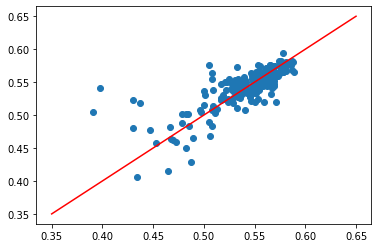

array([[1.        , 0.59231654],
       [0.59231654, 1.        ]])

In [280]:
plt.scatter(test_y.values,pred)
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()

np.corrcoef(test_y.values,pred)**2

In [13]:
np.sqrt(MSE(test_y, [0.5 for i in range(len(test_y))]))

0.05434130450739668

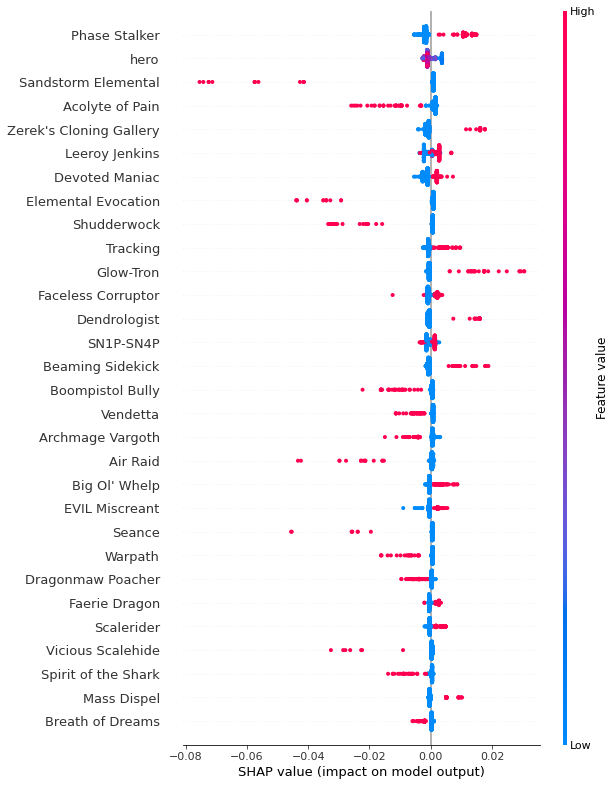

In [15]:
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, max_display=30)

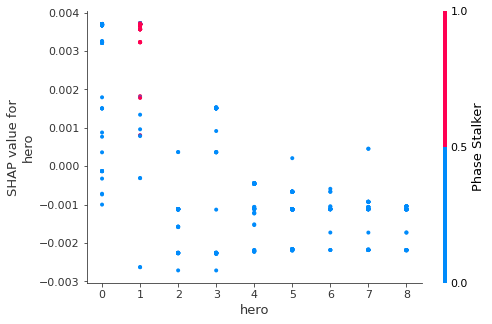

In [16]:
shap.dependence_plot("hero", shap_values, X, interaction_index= 'Phase Stalker')

In [17]:
data['hero'].value_counts()

Rogue      145
Hunter     142
Druid      134
Warrior     65
Mage        62
Paladin     57
Warlock     54
Priest      54
Shaman      23
Name: hero, dtype: int64

In [18]:
# How different cards work in synergy? 

# How win rates for different types look like?

In [19]:
selection = alt.selection_multi(fields=['hero'], bind='legend')

alt.Chart(data).mark_area(
    opacity=0.6,
    interpolate='step'
).encode(
    alt.X('wr:Q', bin=alt.Bin(maxbins=100), title='win rate'),
    alt.Y('count()', stack=None, title='number of decks'),
    alt.Color('hero:N'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))

).add_selection(
    selection
)

alt.Chart(...)

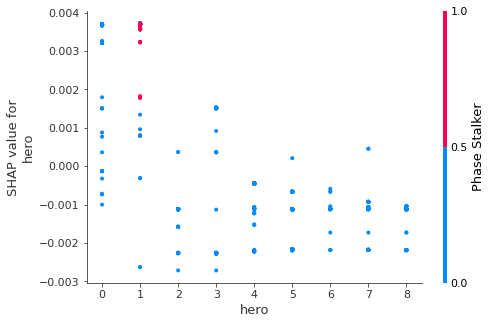

In [30]:
shap.dependence_plot("hero", shap_values, X, interaction_index= 'Phase Stalker')

In [32]:
shap_values.shape

(736, 681)

In [48]:
data.groupby('hero').sum().wins/data.groupby('hero').sum().games

hero
Druid      0.563973
Hunter     0.568252
Mage       0.523529
Paladin    0.563205
Priest     0.563080
Rogue      0.547707
Shaman     0.491850
Warlock    0.545502
Warrior    0.537661
dtype: float64

# Adding Cards info to the initial dataframe

In [535]:
response = r.get('https://api.hearthstonejson.com/v1/68600/enUS/cards.json'
                 ,verify = False)

Unverified HTTPS request is being made to host 'api.hearthstonejson.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


In [536]:
cards_info = pd.read_json(response.content)

In [537]:
# some adjustments for the data

cards_info['neutral_class'] = cards_info.cardClass.apply(lambda x: 1 if x == 'NEUTRAL' else 0)

cards_info = cards_info.astype({'name':'category', 'type':'category'})

In [538]:
# putting some mechanics in separate columns

mechanics = ['BATTLECRY','DEATHRATTLE','TAUNT','AURA','SECRET','DISCOVER','RUSH']

for mech in mechanics:
    cards_info[mech] = cards_info.mechanics.dropna().apply(lambda x: np.isin(x,mech)[0])

cards_info[mechanics] = cards_info[mechanics].fillna(False)*1

In [539]:
cards_info = cards_info.loc[cards_info.name.isin(cards_df.columns)
                            ,['attack', 'neutral_class', 'cost', 'health',
                               'name', 'type','spellDamage', 'BATTLECRY','DEATHRATTLE','TAUNT','AURA'
                              ,'SECRET','DISCOVER','RUSH']]

cards_info

,attack,neutral_class,cost,health,name,type,spellDamage,BATTLECRY,DEATHRATTLE,TAUNT,AURA,SECRET,DISCOVER,RUSH
241,NaN,1,NaN,NaN,Rampage,ENCHANTMENT,NaN,0,0,0,0,0,0,0
399,1.0,1,1.0,1.0,Skaterbot,MINION,NaN,0,0,0,0,0,0,0
400,NaN,1,NaN,NaN,Skaterbot,ENCHANTMENT,NaN,0,0,0,0,0,0,0
404,NaN,0,2.0,NaN,Bomb Toss,SPELL,NaN,0,0,0,0,0,0,0
405,5.0,0,7.0,5.0,Boommaster Flark,MINION,NaN,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689,2.0,1,4.0,3.0,Sky Gen'ral Kragg,MINION,NaN,1,0,0,0,0,0,0
10691,2.0,0,2.0,3.0,Steel Beetle,MINION,NaN,1,0,0,0,0,0,0
10692,NaN,0,10.0,NaN,Eye of the Storm,SPELL,NaN,0,0,0,0,0,0,0
10694,1.0,0,4.0,NaN,The Fist of Ra-den,WEAPON,NaN,0,0,0,0,0,0,0


In [540]:
# some cards will be duplicated as they may have different attributes in different circumstanses. We only keep one variant of a card

cards_info = cards_info.loc[~cards_info.duplicated(subset = ['name'], keep='first')]

In [541]:
def add_card_info(data):
    #this function adding meta data on each card in the deck into the deck dataframe
    data_cards = data

    for i in range(30):
        indx = 'card_'+str(i)
        #print(indx)
        data_cards = pd.merge(data_cards,cards_info
            , how='left'
            , left_on=indx, right_on='name', suffixes=('', indx))
    
    cat = ['card_0', 'card_1', 'card_2', 'card_3', 'card_4', 'card_5', 'card_6',
       'card_7', 'card_8', 'card_9', 'card_10', 'card_11', 'card_12',
       'card_13', 'card_14', 'card_15', 'card_16', 'card_17', 'card_18',
       'card_19', 'card_20', 'card_21', 'card_22', 'card_23', 'card_24',
       'card_25', 'card_26', 'card_27', 'card_28', 'card_29', 'hero']

    data_cards = data_cards.astype({c:'category' for c in cat})

    return data_cards

In [542]:
X, y = data.drop(['type','dust','games','wins'], axis=1), data['wr']

# Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 

In [543]:
# add card data into training and test datasets

X_train = add_card_info(X_train)
X_test = add_card_info(X_test)

In [544]:
y_train, y_test = X_train.wr, X_test.wr
X_train = X_train.drop('wr', axis=1)
X_test = X_test.drop('wr', axis=1)

In [545]:
X_test

,duration,card_0,card_1,card_2,card_3,card_4,card_5,card_6,card_7,card_8,...,namecard_29,typecard_29,spellDamagecard_29,BATTLECRYcard_29,DEATHRATTLEcard_29,TAUNTcard_29,AURAcard_29,SECRETcard_29,DISCOVERcard_29,RUSHcard_29
0,7.2,Embiggen,Acornbearer,Treenforcements,Dendrologist,Hench-Clan Hogsteed,Shrubadier,Landscaping,Savage Roar,Garden Gnome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.5,Backstab,Bloodsail Flybooter,Praise Galakrond!,Sap,Edwin VanCleef,EVIL Miscreant,Magic Carpet,Seal Fate,Devoted Maniac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.4,Mutate,Earth Shock,Earthen Might,Invocation of Frost,Novice Engineer,Witch's Brew,Electra Stormsurge,Far Sight,Haunting Visions,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.5,Backstab,Shadowstep,Pharaoh Cat,Praise Galakrond!,Eviscerate,Edwin VanCleef,EVIL Miscreant,Seal Fate,SN1P-SN4P,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.9,Backstab,Shadowstep,Bloodsail Flybooter,Dragon's Hoard,Pharaoh Cat,Praise Galakrond!,Acidic Swamp Ooze,Eviscerate,Sap,...,Dragonqueen Alexstrasza,MINION,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,6.8,Embiggen,Strength in Numbers,Breath of Dreams,Faerie Dragon,Injured Tol'vir,Bad Luck Albatross,Scalerider,Evasive Feywing,Swipe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,4.9,Arcane Shot,Leper Gnome,Rapid Fire,Timber Wolf,Toxic Reinforcements,Tracking,Explosive Trap,Kobold Sandtrooper,Phase Stalker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,8.5,Backstab,Shadowstep,Dragon's Hoard,Pharaoh Cat,Praise Galakrond!,Eviscerate,Sap,Underbelly Fence,Zephrys the Great,...,Dragonqueen Alexstrasza,MINION,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
219,8.9,Backstab,Shadowstep,Pharaoh Cat,Praise Galakrond!,Eviscerate,Sap,Skyvateer,Edwin VanCleef,EVIL Miscreant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [546]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', MSE(y_test, y_pred)**0.5)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1]	valid_0's l1: 0.0250362	valid_0's l2: 0.00116066
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.0244959	valid_0's l2: 0.00111516
[3]	valid_0's l1: 0.0241196	valid_0's l2: 0.00108555
[4]	valid_0's l1: 0.0236044	valid_0's l2: 0.00105045
[5]	valid_0's l1: 0.0231418	valid_0's l2: 0.00101388
[6]	valid_0's l1: 0.0226775	valid_0's l2: 0.000979265
[7]	valid_0's l1: 0.0222561	valid_0's l2: 0.000949453
[8]	valid_0's l1: 0.0218813	valid_0's l2: 0.000925573
[9]	valid_0's l1: 0.0215537	valid_0's l2: 0.000903902
[10]	valid_0's l1: 0.0212423	valid_0's l2: 0.000883091
[11]	valid_0's l1: 0.0208925	valid_0's l2: 0.000862294
[12]	valid_0's l1: 0.020482	valid_0's l2: 0.000835669
[13]	valid_0's l1: 0.0201721	valid_0's l2: 0.000816104
[14]	valid_0's l1: 0.0199188	valid_0's l2: 0.000796737
[15]	valid_0's l1: 0.0196826	valid_0's l2: 0.000782743
[16]	valid_0's l1: 0.01935	valid_0's l2: 0.000760971
[17]	valid_0's l1: 0.0190403	valid_0's l2: 0.000740286
[18]	valid_0's l1: 0.0

In [547]:
print('The rmse of prediction is:', MSE(y_test, y_pred)**0.5)

The rmse of prediction is: 0.026219658398367346


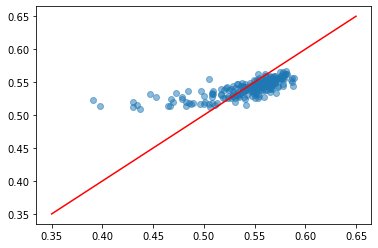

array([[1.        , 0.58247455],
       [0.58247455, 1.        ]])

In [548]:
plt.scatter(y_test.values,y_pred, alpha=.5)
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()
np.corrcoef(y_test.values,y_pred)**2

### The results for the dataframe with all cards and all cards metadata look worse than for the dataframe with one hot encoding for each card. So let's add some new features to the one hot dataframe

In [550]:
cards_info.head()

,attack,neutral_class,cost,health,name,type,spellDamage,BATTLECRY,DEATHRATTLE,TAUNT,AURA,SECRET,DISCOVER,RUSH
241,NaN,1,NaN,NaN,Rampage,ENCHANTMENT,NaN,0,0,0,0,0,0,0
399,1.0,1,1.0,1.0,Skaterbot,MINION,NaN,0,0,0,0,0,0,0
404,NaN,0,2.0,NaN,Bomb Toss,SPELL,NaN,0,0,0,0,0,0,0
405,5.0,0,7.0,5.0,Boommaster Flark,MINION,NaN,1,0,0,0,0,0,0
406,2.0,0,2.0,2.0,Venomizer,MINION,NaN,0,0,0,0,0,0,0


In [551]:
cards_info.TAUNT.value_counts()

0    674
1      6
Name: TAUNT, dtype: int64

In [552]:
cards_df.head()

,A New Challenger...,Abusive Sergeant,Abyssal Summoner,Acidic Swamp Ooze,Acolyte of Pain,Acornbearer,Activate the Obelisk,Aeroponics,Air Raid,Aldor Peacekeeper,...,"Ysera, Unleashed",Zandalari Templar,Zap!,Zentimo,Zephrys the Great,Zerek's Cloning Gallery,Zilliax,Zul'jin,Zzeraku the Warped,hero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0


In [553]:
def add_meta_to_deck(deck):
    
    card_mask = deck

    # number of cards with BATTLECRY	DEATHRATTLE	TAUNT	AURA	SECRET	DISCOVER	RUSH
    meta_data = cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),['BATTLECRY','DEATHRATTLE','TAUNT',
                                                    'AURA','SECRET','DISCOVER','RUSH']].sum()

    #costs of cards
    costs = cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),'cost'].value_counts()
    costs.index = ['cost_'+str(int(i)) for i in costs.index]

    meta_data = meta_data.append(costs)

    #types of cards
    card_types = cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),'type'].value_counts()
    #costs.index = ['cost_'+str(int(i)) for i in costs.index]
    meta_data = meta_data.append(card_types)

    return deck.append(meta_data)

In [554]:
pd.DataFrame(add_meta_to_deck(cards_df.loc[0])).T

,A New Challenger...,Abusive Sergeant,Abyssal Summoner,Acidic Swamp Ooze,Acolyte of Pain,Acornbearer,Activate the Obelisk,Aeroponics,Air Raid,Aldor Peacekeeper,...,cost_3,cost_8,SPELL,MINION,HERO,WEAPON,MOVE_MINION_HOVER_TARGET,HERO_POWER,GAME_MODE_BUTTON,ENCHANTMENT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,11.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0


A New Challenger...        0.0
Abusive Sergeant           0.0
Abyssal Summoner           0.0
Acidic Swamp Ooze          0.0
Acolyte of Pain            0.0
                          ... 
Zerek's Cloning Gallery    1.0
Zilliax                    1.0
Zul'jin                    0.0
Zzeraku the Warped         0.0
hero                       4.0
Name: 0, Length: 681, dtype: float64

In [555]:
cards_info.loc[cards_info.name.isin(card_mask[card_mask>0].index),['BATTLECRY','DEATHRATTLE','TAUNT',
                                                    'AURA','SECRET','DISCOVER','RUSH']].sum()

BATTLECRY      2
DEATHRATTLE    3
TAUNT          0
AURA           0
SECRET         0
DISCOVER       0
RUSH           0
dtype: int64

In [446]:
#cards_df.apply(lambda x: add_meta_to_deck(x))

cards_df_meta = pd.DataFrame(add_meta_to_deck(cards_df.loc[i]))

for i in cards_df.index:
    cards_df_meta[i] = add_meta_to_deck(cards_df.loc[i])

cards_df_meta

,0,1,2,3,4,5,6,7,8,9,...,726,727,728,729,730,731,732,733,734,735
A New Challenger...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abusive Sergeant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abyssal Summoner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acidic Swamp Ooze,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acolyte of Pain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEAPON,0.0,1.0,2.0,1.0,1.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MOVE_MINION_HOVER_TARGET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HERO_POWER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAME_MODE_BUTTON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [556]:
X, y = cards_df_meta.T, data['wr']

In [557]:
# Splitting 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 100, seed = 123) 
  
# Fitting the model 
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_X) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.024894


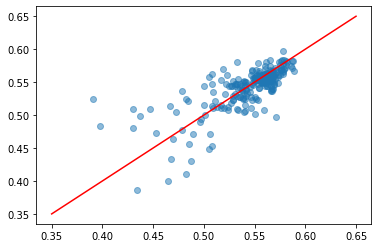

array([[1.        , 0.53627001],
       [0.53627001, 1.        ]])

In [558]:
plt.scatter(test_y.values,pred, alpha=.5)
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()

np.corrcoef(test_y.values,pred)**2

In [559]:
X.shape

(736, 705)

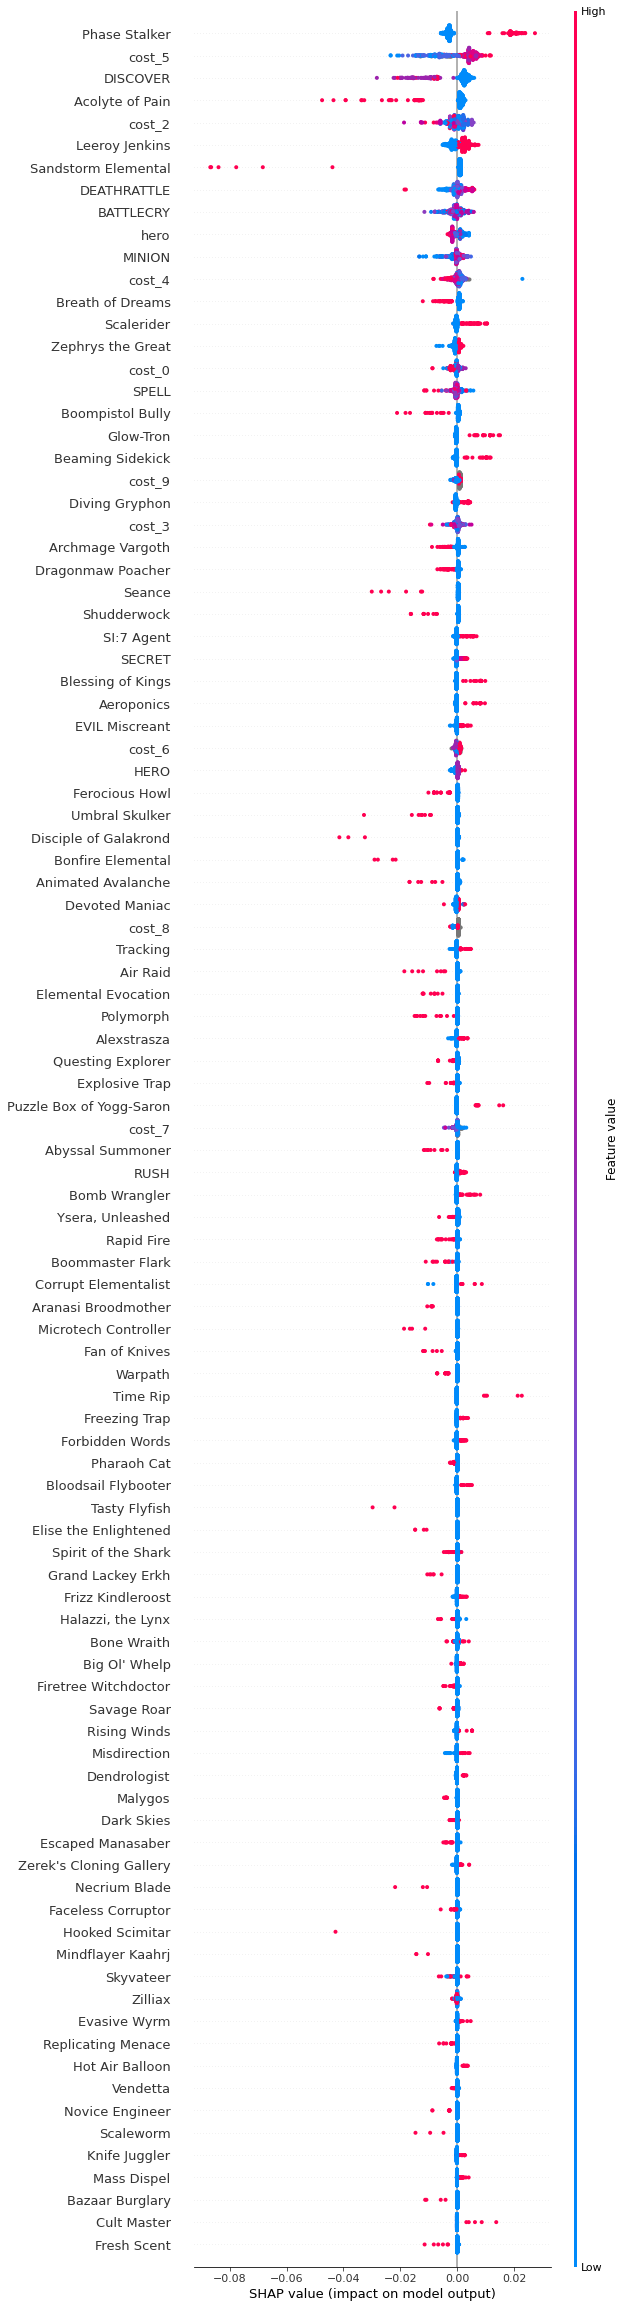

In [488]:
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(train_X)

# summarize the effects of all the features
shap.summary_plot(shap_values, train_X, max_display=100)

In [490]:
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(train_X)
shap_df = pd.DataFrame(shap_values, index=train_X.index)
train_merged = train_X.join(shap_df)

In [491]:
shap_values = explainer.shap_values(test_X)
shap_df = pd.DataFrame(shap_values, index=test_X.index)
test_merged = test_X.join(shap_df)

In [495]:
# Fitting the model 
xgb_r.fit(train_merged, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_merged) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(test_y, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.024271


In [497]:
1 - 0.024271/0.024894

0.025026110709407856

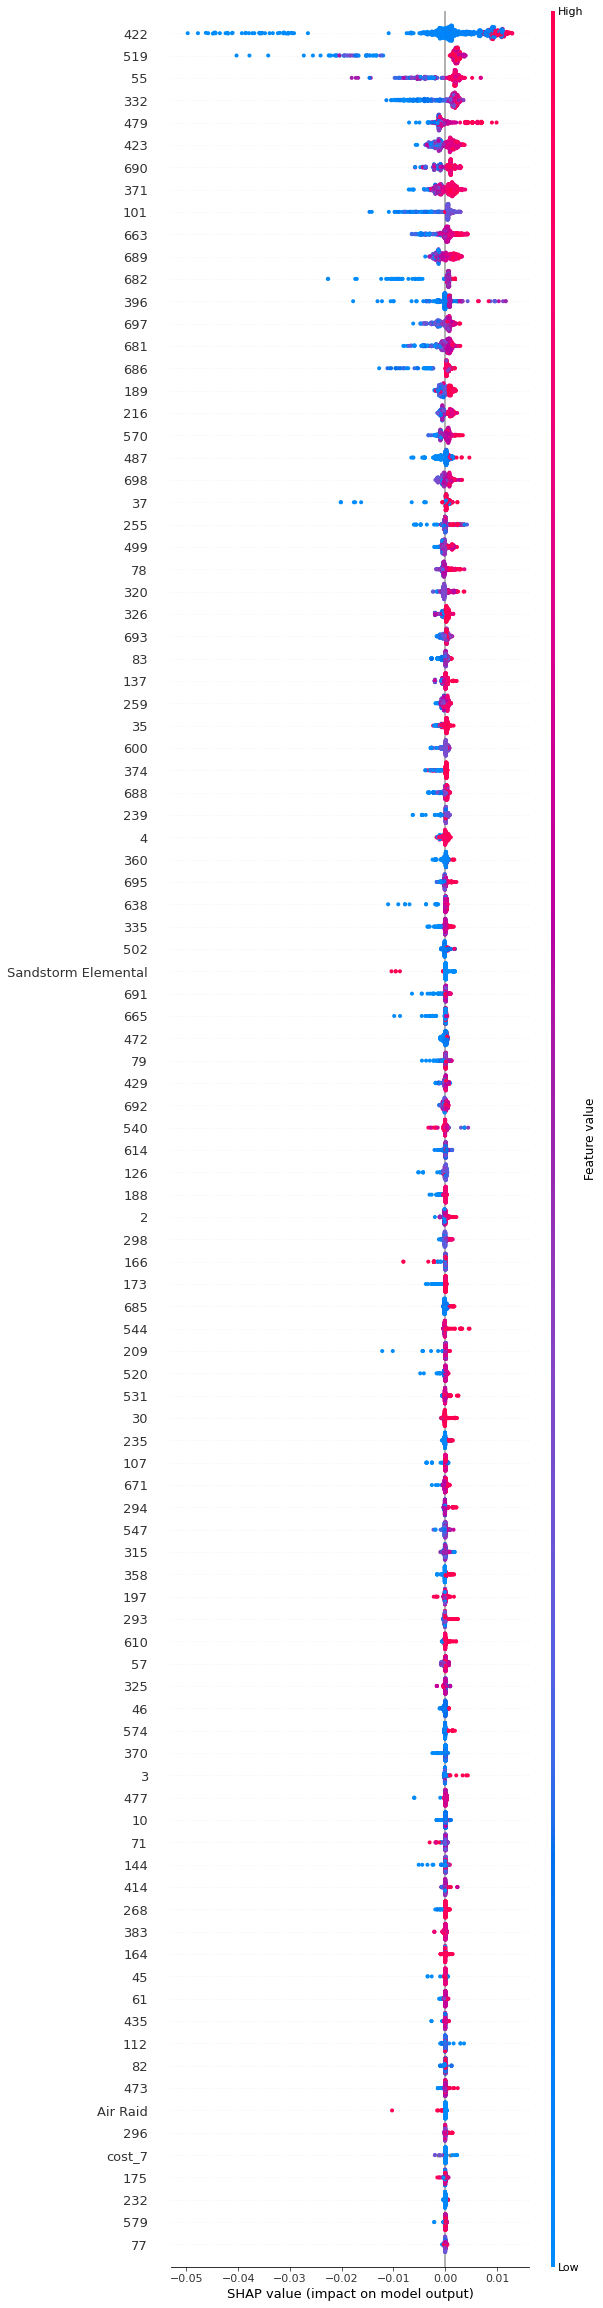

In [508]:
explainer = shap.TreeExplainer(xgb_r)

shap_values = explainer.shap_values(train_merged)

shap.summary_plot(shap_values, train_merged, max_display=100)

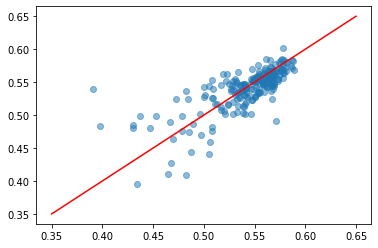

array([[1.        , 0.55422704],
       [0.55422704, 1.        ]])

In [513]:
plt.scatter(test_y.values,pred, alpha=.5)
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()

np.corrcoef(test_y.values,pred)**2

## Cross validation

In [523]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [533]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  shuffle=True, random_state=1) 


# prepare cross validation
kfold = KFold(10, True, 1)

rmse = np.zeros(10)
i=0
# enumerate splits
for train, test in kfold.split(X):
    
    xgb_r.fit(X.iloc[train], y.iloc[train])
    pred = xgb_r.predict(X.iloc[test]) 
    rmse[i] = np.sqrt(MSE(y.iloc[test], pred))
    i+=1

Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error


[00:41:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { shuffle } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:41:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { shuffle } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:41:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { shuffle } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip throug

In [534]:
rmse

array([0.01945131, 0.02742846, 0.02262092, 0.01547532, 0.02166677,
       0.02332541, 0.0259915 , 0.02292817, 0.0191815 , 0.02056239])